# Reading and plotting Planet Imagery
---
This notebook is designed to be a first pass at analyzing planet imagery

In [2]:
### First we import the glob package, which is useful for searching directories and collecting file names
import glob as glob

### Then we import the packages that are designed for reading this style of imagery into python -- xarray and rioxarray
import xarray as xr
import rioxarray as rxr
import json
import folium
import numpy as np
import matplotlib.pyplot as plt


### Then we create an object that points to the directory containing the images
datadir = '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/'

### Finally, we use glob to search that directory for the names of relevant files
fns = glob.glob(datadir+'*.tif')
fns = sorted(fns)

In [3]:
### Let's print the list of filenames
fns

['/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_222959_0e20_3B_AnalyticMS_DN_udm_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_222959_0e20_3B_AnalyticMS_SR_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_222959_0e20_3B_udm2_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_223000_0e20_3B_AnalyticMS_DN_udm_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_223000_0e20_3B_AnalyticMS_SR_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210805_223000_0e20_3B_udm2_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210813_225323_1013_3B_AnalyticMS_DN_udm_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210813_225323_1013_3B_AnalyticMS_SR_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210813_225323_1013_3B_udm2_clip.tif',
 '/mnt/data01/Data/PlanetImagery/NauruImagery_v1/20210813_225324_1013_3B_AnalyticMS_DN_udm_clip.tif',
 '/mnt/data01/Data/PlanetImager

In [4]:
### It appears as though each downloaded image comes with three different files -- this website seems to describe what they are: https://developers.planet.com/docs/data/psscene4band/
metafiles = sorted(glob.glob(datadir+'*.json'))

### udm2*  Usable Data Mask 2.0. 
fns1 = sorted(glob.glob(datadir+'*udm2*.tif'))
### analytic_dn	  Non-radiometrically calibrated GeoTiff product suitable for analytic applications.
fns2 = sorted(glob.glob(datadir+'*AnalyticMS_DN*.tif'))
### analytic_sr*  Atmospherically corrected surface reflectance product. -- THIS SEEMS TO BE THE ONE TO USE
fns3 = sorted(glob.glob(datadir+'*AnalyticMS_SR*.tif'))

############# The 4 bands are: Blue, Green, Red, Near-Infrared

print(len(metafiles), len(fns1),len(fns2),len(fns3))

9 9 9 9


In [5]:
### Let's look at the fifth file
file_ind = 4;

file_in_use = fns3[file_ind]
file_ending = file_in_use.split('/')[-1]

fid = open(metafiles[file_ind])
metadata = json.load(fid)

### Here we load in the first file that has udm2_clip in the name, and take a look.
### It appears to have 8 different bands, which is interesting. 
imdata1 = rxr.open_rasterio(file_in_use)
imdata1 = imdata1.rio.set_crs(32758)

map_data = imdata1.rio.reproject("EPSG:4326");
image_matrix = np.moveaxis(map_data.isel(band=[0,1,2]).values,[0,1,2],[2,0,1])

In [260]:
metadata

{'id': '20210813_225325_1013',
 'type': 'Feature',
 'geometry': {'coordinates': [[[166.94990656202953, -0.618821190741462],
    [166.7279811778465, -0.576434047091201],
    [166.7423947366315, -0.504707383702696],
    [166.96313770639208, -0.547429903501222],
    [166.96090999941137, -0.558801766953064],
    [166.96168308135123, -0.558950972636423],
    [166.94990656202953, -0.618821190741462]]],
  'type': 'Polygon'},
 'properties': {'acquired': '2021-08-13T22:53:25.472537Z',
  'anomalous_pixels': 0.1,
  'clear_confidence_percent': 97,
  'clear_percent': 100,
  'cloud_cover': 0,
  'cloud_percent': 0,
  'columns': 8728,
  'epsg_code': 32758,
  'ground_control': True,
  'gsd': 3.8,
  'heavy_haze_percent': 0,
  'instrument': 'PS2',
  'item_type': 'PSScene4Band',
  'light_haze_percent': 0,
  'origin_x': 692298,
  'origin_y': 9944190,
  'pixel_resolution': 3,
  'provider': 'planetscope',
  'published': '2021-08-14T04:20:33Z',
  'publishing_stage': 'standard',
  'quality_category': 'standard

In [248]:
#Create the map
my_map = folium.Map(width=1000,height=500,location=[-0.5, 166.9],zoom_start = 13)

overlay1 = folium.raster_layers.ImageOverlay(
    image=image_matrix,
    bounds=[[map_data['y'].min().values.tolist(),map_data['x'].min().values.tolist()],[map_data['y'].max().values.tolist(),map_data['x'].max().values.tolist()]],
    origin='upper',
    interactive=True,   
    opacity=0.8,
)

folium.Popup(file_ending).add_to(overlay1)

overlay1.add_to(my_map)

#Display the map
my_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


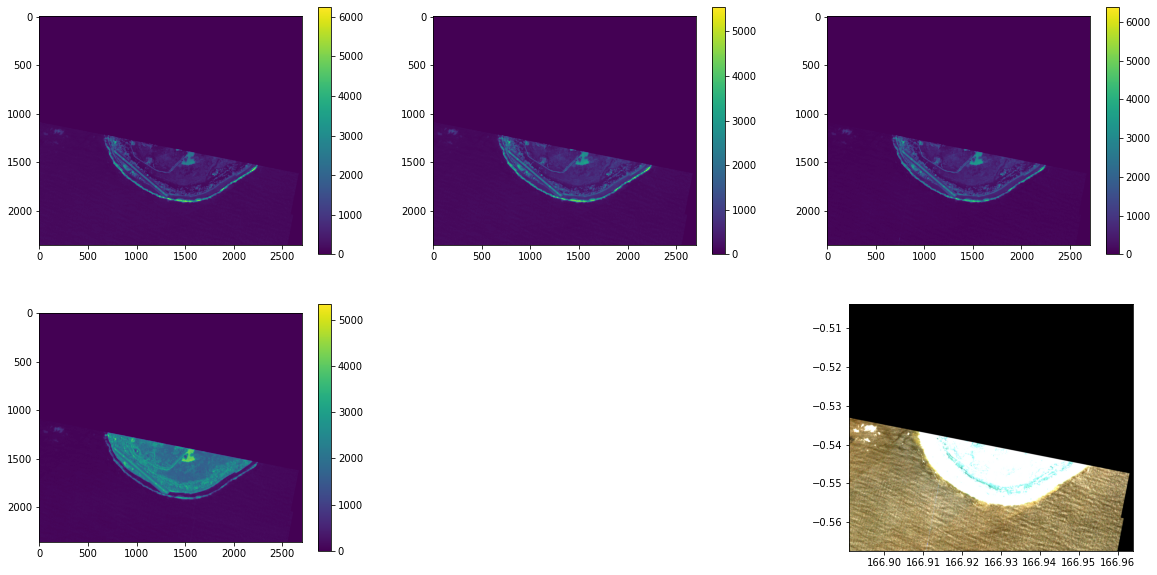

In [246]:

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(np.squeeze(map_data.isel(band=[0]).values))
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.squeeze(map_data.isel(band=[1]).values))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(np.squeeze(map_data.isel(band=[2]).values))
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(np.squeeze(map_data.isel(band=[3]).values))
plt.colorbar()


plt.subplot(2,3,6)
image_matrix = np.moveaxis(map_data.isel(band=[0,1,2]).values,[0,1,2],[2,0,1])
image_matrix = image_matrix.astype('float64')/256
plt.imshow(image_matrix,extent=[map_data['x'].min().values,map_data['x'].max().values,map_data['y'].min().values,map_data['y'].max().values])